In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import stats
from scipy import signal
import sys

### 目标模拟器
#### 1.基本参数
* 脉冲宽度pluseWidth
* 重复频率prf
* 载频carrierFreq

#### 2.调制方式
* 方波
* 线性调频
 
$y=e^{j{\pi}\frac{B}{\tau}t^2}$

*B为扫频宽度，$\tau$为脉冲宽度*

#### 3.目标参数
* 距离 R
* 速度 V
* 横截面积 rcs

#### 4.干扰参数
* 噪声
 * 高斯白噪声
* 有源欺骗干扰

#### 5.雷达方程
$P_r=\frac{P_tG_tG_rc^2\sigma}{(4\pi)^3R^4f^2L}$

$A_r=\sqrt{P_r}$

#### 6.IQ混频
$cos(2{\pi}f_0t－{\pi}\frac{B}{\tau}t^2)=cos(2{\pi}f_0t)*cos({\pi}\frac{B}{\tau}t^2)+sin(2{\pi}f_0t)*sin({\pi}\frac{B}{\tau}t^2)$


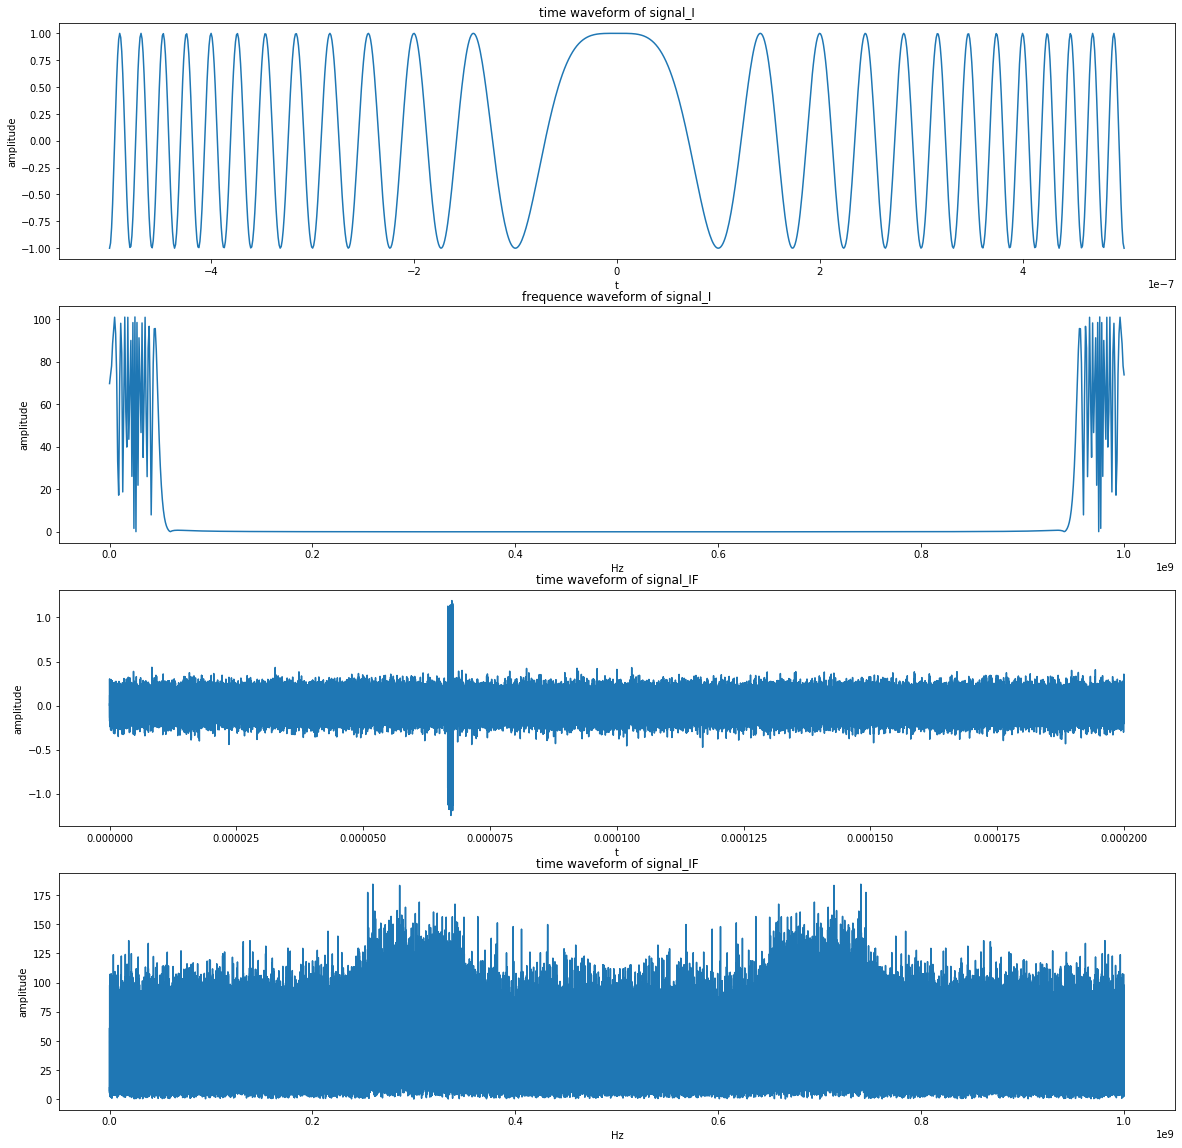

CPU times: user 1.89 s, sys: 4 ms, total: 1.9 s
Wall time: 1.91 s


In [13]:
%%time

pluseWidth = 1e-6    # 脉冲宽度(持续时间s)
prf = 5e3            # 重复频率Hz
modType = 1          # 0：方波；1：线性调频
B = 1e8              # 扫频宽度
carrierFreq = 3e8    # 载频Hz

fs = 1e9            # 采样频率Hz

R = 1e4              # 目标距离m
V = 500              # 目标径向速度m/s
rcs = 100            # 目标横截面积m2

Pt = 1e3             # 发射功率w
G = 1e3              # 收发增益
L = 1                # 损耗

lightSpeed = 3e8     # 光速

#############################################

def wave_create(modType, pluseWidth, prf, carrierFreq, fs, R, V):

    if R > lightSpeed/(prf*2):
        sys.exit("目标距离模糊")
    elif V > prf*lightSpeed/(carrierFreq*2):
        sys.exit("目标速度模糊")

    t = np.linspace(-pluseWidth/2, pluseWidth/2, int(fs*pluseWidth))
    T = np.linspace(0, 1/prf, int(fs/prf))

    if modType == 0:
        sig_I = np.ones(len(t))
        sig_Q = np.zeros(len(t))
    elif modType == 1:
        sig = np.exp(1j*np.pi*B/pluseWidth*(t**2))
        sig_I = np.real(sig)
        sig_Q = np.imag(sig)
    else:
        pass

    dopplerFreq = 2*V/(3e8/carrierFreq)  # 多普勒频移补偿
    sig_IF = np.cos(2*np.pi*(carrierFreq+dopplerFreq)*t)*sig_I + \
        np.sin(2*np.pi*(carrierFreq+dopplerFreq)*t)*sig_Q
    sig_IF = np.concatenate((np.zeros(int(2*R/lightSpeed*fs)), sig_IF))
    sig_IF = np.concatenate((sig_IF, np.zeros(len(T)-len(sig_IF))))

    return sig_IF, sig_I, sig_Q

#############################################

t = np.linspace(-pluseWidth/2, pluseWidth/2, int(fs*pluseWidth))
T = np.linspace(0, 1/prf, int(fs/prf))

##### 噪声产生

G_amp = 0.1  # 高斯白噪声幅度
G_var = 1  # 高斯白噪声方差

G_noise = G_amp*stats.norm.rvs(loc=0, scale=G_var, size=int(fs/prf))

##### 生成波形

sig_IF, sig_I, sig_Q = wave_create(modType, pluseWidth, prf, carrierFreq, fs, R, V)
sig_IF += G_noise

##### 傅里叶变换

fftI = np.abs(np.fft.fft(sig_I))
fftIF = np.abs(np.fft.fft(sig_IF))

##### 画图

plt.figure(figsize=(20, 20))

plt.subplot('411')
plt.plot(t, sig_I)
plt.xlabel('t')
plt.ylabel('amplitude')
plt.title('time waveform of signal_I')

plt.subplot('412')
plt.plot(np.linspace(0, fs, int(fs*pluseWidth)), fftI)
plt.xlabel('Hz')
plt.ylabel('amplitude')
# plt.yscale('log')
# plt.xlim(xmin=0,xmax=1e8)
plt.title('frequence waveform of signal_I')


plt.subplot('413')
plt.plot(T, sig_IF)
plt.xlabel('t')
plt.ylabel('amplitude')
plt.title('time waveform of signal_IF')


plt.subplot('414')
plt.plot(np.linspace(0, fs, int(fs/prf)), fftIF)
plt.xlabel('Hz')
plt.ylabel('amplitude')
plt.title('time waveform of signal_IF')
plt.show()

### 雷达信号处理
#### IQ解调
$cos(a-b)*cos(a)=\frac{1}{2}[cos(b)+cos(2a-b)]$

$cos(a-b)*sin(a)=\frac{1}{2}[sin(b)+sin(2a-b)]$

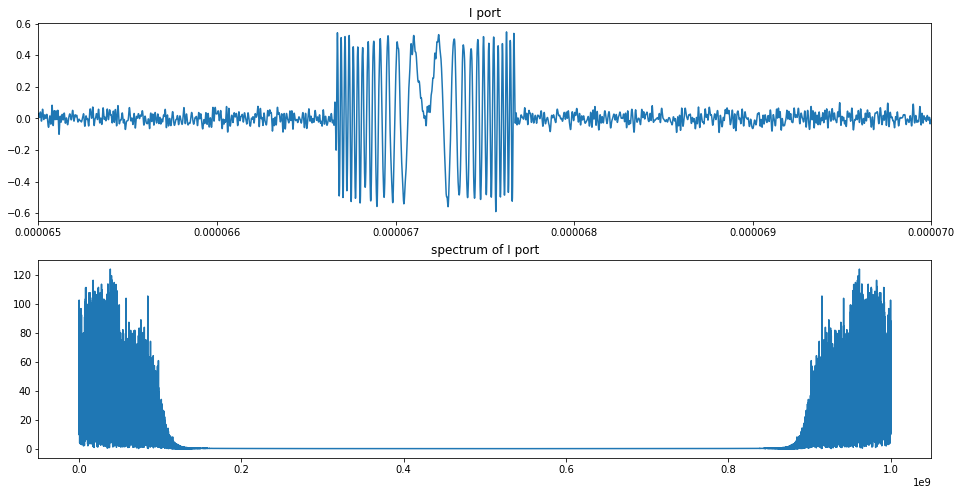

In [14]:
#### 混频、低通滤波
mm,nn = signal.butter(8,2*1e8/fs,'lowpass') # 配置低通滤波器
sig_IR = signal.filtfilt(mm,nn,sig_IF*np.cos(2*np.pi*carrierFreq*T))
sig_QR = signal.filtfilt(mm,nn,sig_IF*np.sin(2*np.pi*carrierFreq*T))

#### 画图

plt.figure(figsize=(16,8))
plt.subplot('211')
plt.plot(T,sig_IR)
plt.xlim(xmin=6.5e-5,xmax=7e-5)
plt.title('I port')

plt.subplot('212')
plt.plot(np.linspace(0,fs,int(fs/prf)),np.abs(np.fft.fft(sig_IR)))
# plt.yscale('log')
plt.title('spectrum of I port')
plt.show()

### 匹配滤波
$y(t)=\int_{-\propto}^{+\propto}x(u)h(t-u)du$

$y(t)=IFFT[X(j\omega)H^*(j\omega)e^{-j{\omega}t_0}]$


目标距离: 10149.75


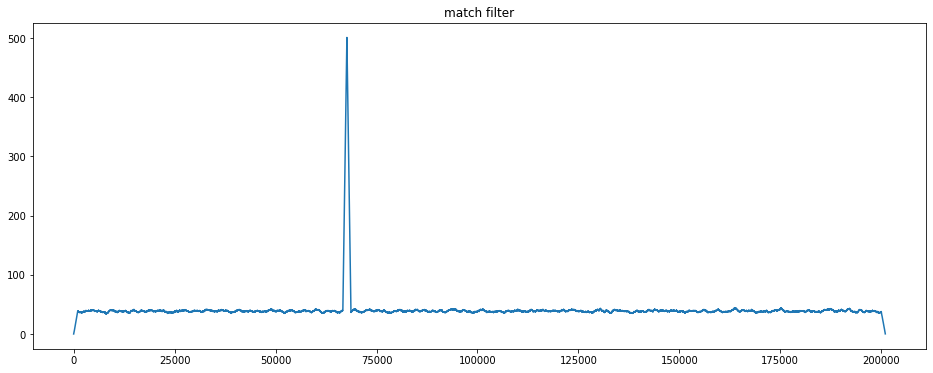

In [19]:
#### 与原信号卷积
sig_match = np.convolve(np.abs(sig_IR+1j*sig_QR),np.abs(sig_I+1j*sig_Q))

#### 提取目标距离
distenceT = np.where(sig_match==np.max(sig_match))[0][0]/fs*lightSpeed/2
print('目标距离:',distenceT)

#### 画图
plt.figure(figsize=(16,6))
plt.plot(sig_match)
plt.title('match filter')
plt.show()
